# Lecture 18 Part 2 - PCA Implementations & Applications

---

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [6]:
# Helper functions

def plotvec(*argv):
    colors=['k','b','r','g','c','m']
    xmin=0
    xmax=-1000000
    ymin=0
    ymax=-1000000
    origin=[0,0]
#     plt.figure()
    for e in enumerate(argv):
        i=e[0]
        arg=e[1]
        plt.quiver(*origin,*arg,angles='xy',scale_units='xy',scale=1,
                   color=colors[i%len(colors)])
        xmin=min(xmin,arg[0])
        xmax=max(xmax,arg[0])
        ymin=min(ymin,arg[1])
        ymax=max(ymax,arg[1])
#     plt.xlim(min(-1, xmin-1), max(1,xmax+1))
#     plt.ylim(min(-1,ymin-1),max(1,ymax+1))

def plot_contours(K,X=None, R=None):
    '''This function plots the contours of a Bivariate Gaussian RV with
    mean [0,0] and covariance K'''
    
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    xm, ym = np.meshgrid(x, np.flip(y))
    if X is None:
        X = np.dstack([xm,ym])
    if R is not None:
        X = X@R
    
    G = stats.multivariate_normal.pdf(X,mean=[0,0],cov=K)
    
    plt.figure(figsize=(6,6))
    plt.contour(xm,ym,G, extent=[-3,3,-3,3],cmap='viridis');
    
def makerot(theta):
    '''This function creates a 2x2 rotation 
    matrix for a given angle (theta) in degrees'''
    
    theta=np.radians(theta)
    
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    
    return R

In [7]:
import scipy.stats as stats

data = stats.multivariate_normal([0,0],[[1,0.8],[0.8,2]]).rvs(size=100)

data.shape

(100, 2)

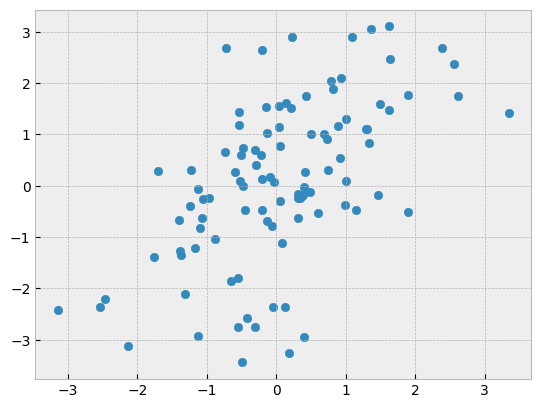

In [8]:
plt.scatter(data[:,0],data[:,1]);

In [9]:
# Covariance matrix of input matrix
K = np.cov(data.T)

K

array([[1.28769712, 1.02672147],
       [1.02672147, 2.50736883]])

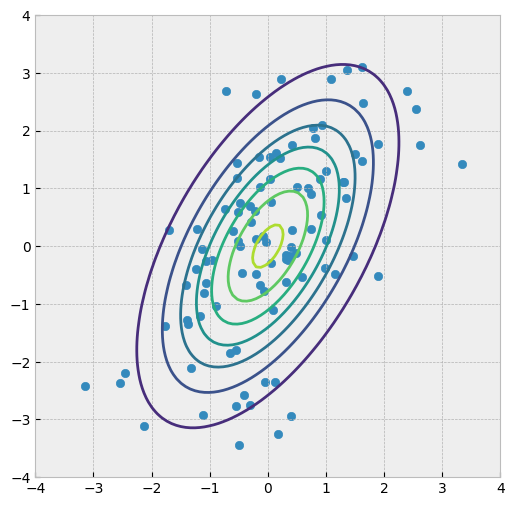

In [10]:
plot_contours(K)
plt.scatter(data[:,0],data[:,1]);

In [11]:
# Eigendecomposition
L, V = np.linalg.eigh(K)

L, V

(array([0.70335679, 3.09170915]),
 array([[-0.86910153,  0.49463373],
        [ 0.49463373,  0.86910153]]))

In [12]:
# Sort eigenvalues and eigenvectors in decreasing order of eigenvalues

L=L[::-1]

V=V[:,::-1]

L, V

(array([3.09170915, 0.70335679]),
 array([[ 0.49463373, -0.86910153],
        [ 0.86910153,  0.49463373]]))

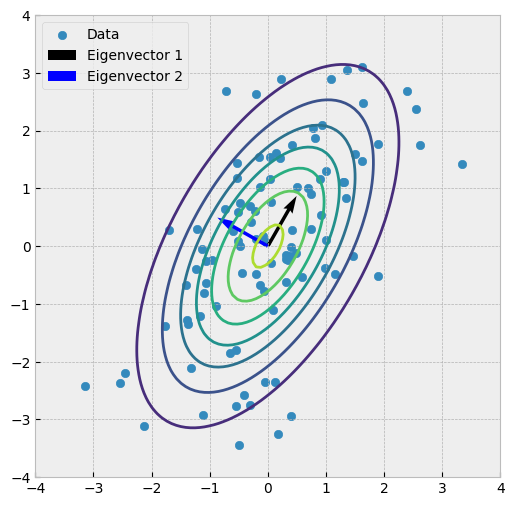

In [13]:
plot_contours(K)
plt.scatter(data[:,0],data[:,1])
plotvec(V[:,0], V[:,1])
plt.legend(['Data','Eigenvector 1', 'Eigenvector 2']);

In [14]:
# Apply PCA to preserve dimensions == rotating the data
rotated =  V.T@data.T

rotated.shape

(2, 100)

In [15]:
# Check the covariance of PCA transformation
K2 = np.cov(rotated)

np.round(K2,7)

array([[3.0917092, 0.       ],
       [0.       , 0.7033568]])

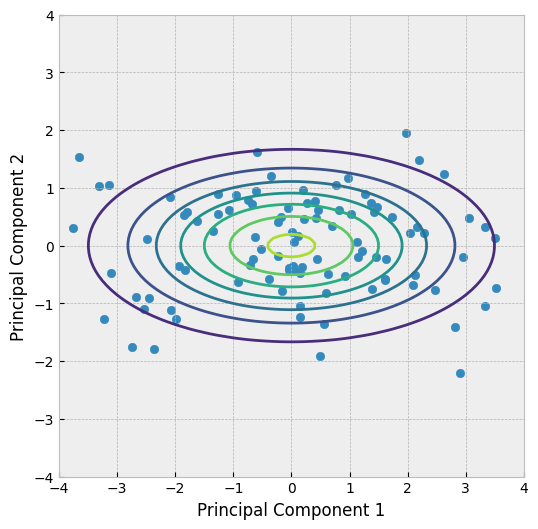

In [16]:
plot_contours(K2)
plt.scatter(rotated[0,:],rotated[1,:])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

In [17]:
# standard unit vector
e1=np.array([[1],[0]])

angle = np.degrees(np.arccos((e1.T@V[:,0])/(np.linalg.norm(e1)*np.linalg.norm(V[:,0]))))[0]

angle

60.35439904480175

In [18]:
# Apply manual rotation 

rotated2 = makerot(-angle)@data.T

In [19]:
K3 = np.cov(rotated2)

np.round(K3,7)

array([[3.0917092, 0.       ],
       [0.       , 0.7033568]])

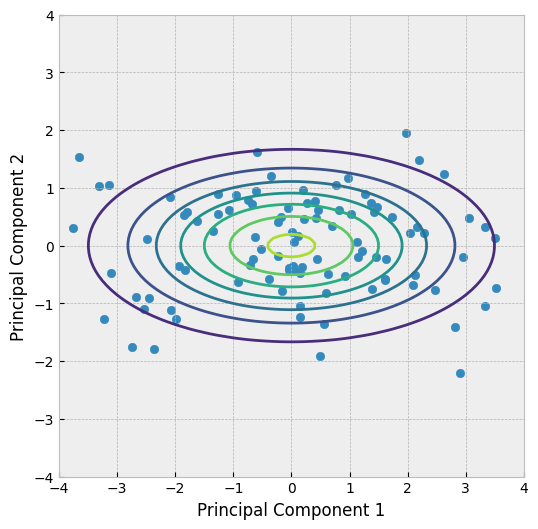

In [20]:
plot_contours(K3)
plt.scatter(rotated2[0,:],rotated2[1,:])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

---

In [21]:
import pandas as pd
from scipy import stats
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
plt.rcParams['axes.grid'] = False

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [22]:
def myPCA(X, m, display=1):
    '''This function implements PCA. The data matrix X is DxN matrix, 
    where D is the dimension and N the number of points'''
    
    D, N = X.shape
    
    # Demean the Data
    data = X
    
    # Covariance of the input data X
    cov_mat = np.cov(data) # is data were to be NxD, np.cov(data.T)
    
    # Find eigenvectors and eigenvalues 
    eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
    # eigendecomposition for Hermitian matrices (positive-definite matrices)-which is the case for covariance matrices
    
    # Sort eigenvectors by magnitude of eigenvalues
    L = eigen_vals[::-1]
    U = eigen_vecs[:,::-1]
    
    # Linear transformation
    A = U[:,:m]
    
    #compute explained variance and plot
    cuml_var_exp=0
    total = sum(L)
    var_explained = [(i/total) for i in L]
    cuml_var_exp = np.cumsum(var_explained)
    if display:
        plt.bar(range(1,D+1), var_explained, alpha=0.5, align='center', label='individual explained variance')
        plt.step(range(1,D+1), cuml_var_exp, alpha=0.5, where='mid', label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best');
    return A, var_explained

---

Coming back to the wine dataset:

In [23]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [24]:
t = df_wine['Class label'].values
X = df_wine.drop(['Class label'], axis=1).values

X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                    test_size=0.3, 
                                                    stratify=t)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

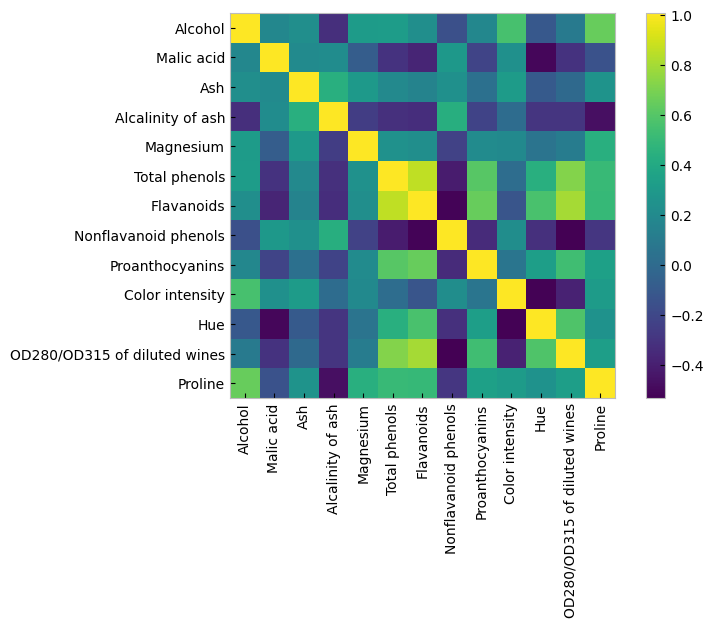

In [25]:
cov_train = np.cov(X_train.T)

plt.figure(figsize=(8,5))
plt.imshow(cov_train)
plt.colorbar()
plt.xticks(range(13),df_wine.columns[1:],rotation=90)
plt.yticks(range(13),df_wine.columns[1:]);

In [26]:
X_train.shape

(124, 13)

(13, 13)

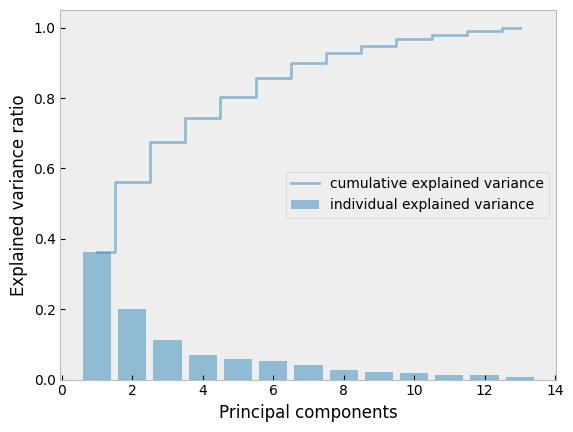

In [27]:
A,var_explained = myPCA(X_train.T, 13)

A.shape

The resulting plot indicates that the first principal component alone accounts for 40 percent of the variance. Also, we can see that the first two principal components combined explain almost 60 percent of the variance in the data.

Although the explained variance plot reminds us of the feature importance, we shall remind ourselves that PCA is an unsupervised method, which means that information about the class labels is ignored.

In [28]:
np.where(np.cumsum(var_explained)>=0.9)

(array([ 7,  8,  9, 10, 11, 12], dtype=int64),)

In [29]:
X_train_pca = A.T@X_train.T

print(X_train.shape, X_train_pca.shape)

(124, 13) (13, 124)


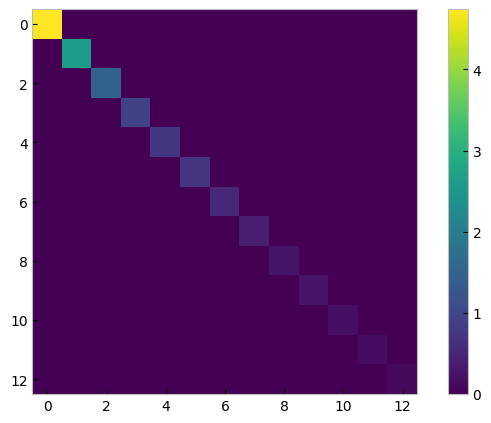

In [30]:
cov_mat = np.cov(X_train_pca)

plt.figure(figsize=(8,5))
plt.imshow(cov_mat)
plt.colorbar();

## PCA with ```scikit-learn```

In [31]:
from sklearn.decomposition import PCA

In [32]:
PCA?

Init signature:
PCA(
    n_components=None,
    *,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    n_oversamples=10,
    power_iteration_normalizer='auto',
    random_state=None,
)
Docstring:     
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

For a usage example, see
:ref:`sphx_glr_auto_examples_decomposition_plot_pca_iris.py`

Read more in the 

In [33]:
pca = PCA(n_components=13)
pca

PCA(n_components=13)

In [34]:
pca.fit(X_train)

PCA(n_components=13)

In [35]:
pca.explained_variance_ratio_

array([0.36191771, 0.19946694, 0.11217017, 0.07067914, 0.05928309,
       0.05403732, 0.04128999, 0.02830445, 0.02076498, 0.01843724,
       0.01297146, 0.01226998, 0.00840752])

In [36]:
np.cumsum(pca.explained_variance_ratio_)

array([0.36191771, 0.56138466, 0.67355483, 0.74423397, 0.80351705,
       0.85755438, 0.89884437, 0.92714882, 0.9479138 , 0.96635104,
       0.9793225 , 0.99159248, 1.        ])

In [37]:
# The matrix A = U.T is 
pca.components_.shape, #MxD

((13, 13),)

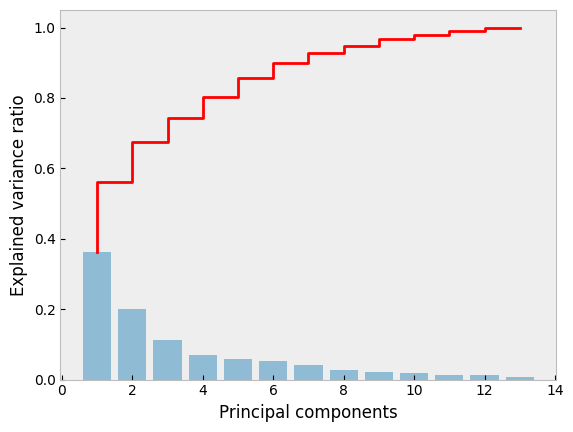

In [38]:
plt.step(range(1,14),np.cumsum(pca.explained_variance_ratio_),c='r')
plt.bar(range(1,14),pca.explained_variance_ratio_, alpha=0.5)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components');

In [39]:
y_train_pca = pca.transform(X_train)

y_train_pca.shape

(124, 13)

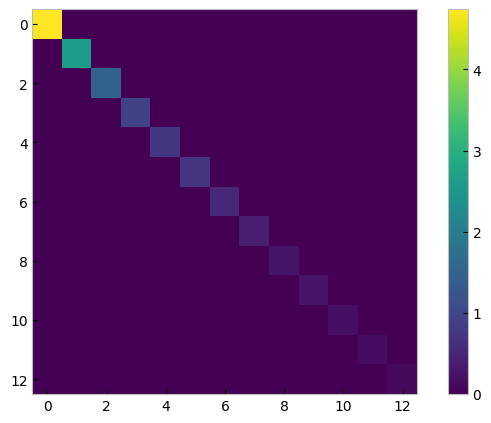

In [40]:
cov_mat = np.cov(y_train_pca.T)

plt.figure(figsize=(8,5))
plt.imshow(cov_mat)
plt.colorbar();

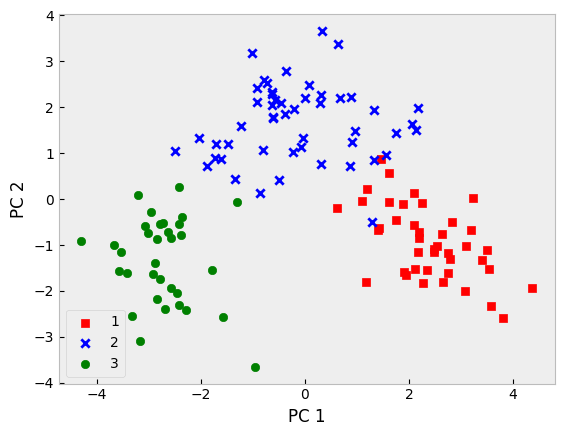

In [41]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(t_train), colors, markers):
    plt.scatter(y_train_pca[t_train==l, 0], y_train_pca[t_train==l, 1],c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

The training data is used to find the new features (eigenvectors). We can then represent the test set in this new feature space:

In [42]:
y_test_pca = pca.transform(X_test)

y_test_pca.shape

(54, 13)

---

## Example: Concentric Circles

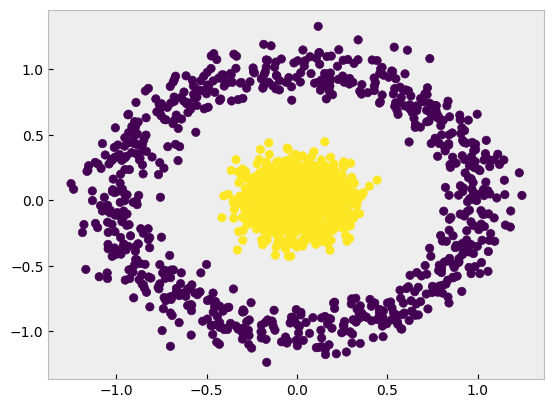

In [43]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1500, noise=0.1, factor=0.2)

plt.scatter(X[:,0],X[:,1],c=y);

ValueError: 'c' argument has 1500 elements, which is inconsistent with 'x' and 'y' with size 400.

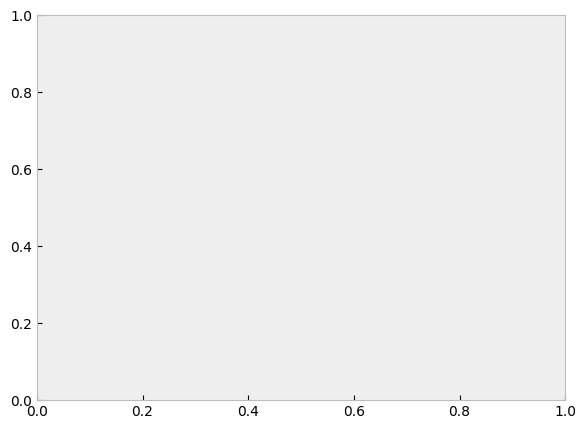

In [65]:
pca = PCA(n_components = 2)
X_spca = pca.fit_transform(X)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X_spca[:,0], X_spca[:,1], c=y, alpha=0.5)
plt.subplot(1,2,2)
plt.scatter(X_spca[:,0], np.zeros(len(X_spca[:,0])), c=y, alpha=0.5)
plt.xlabel('PC1');

## Kernel PCA

There are other variants of PCA such as **Kernel PCA**, where we first project the data to a space where classes are linearly separable (RBF kernel) and then apply PCA:

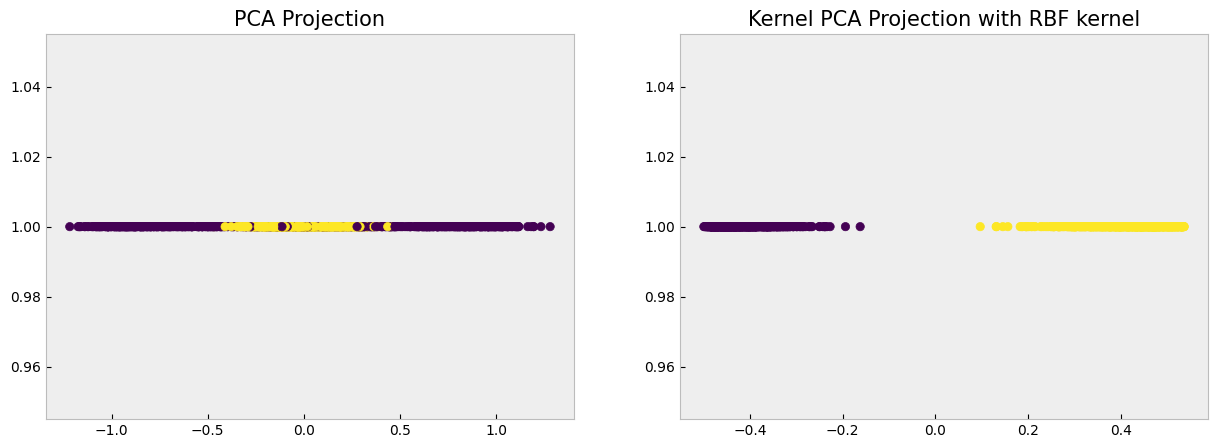

In [45]:
from sklearn.decomposition import KernelPCA

model_pca = PCA(n_components=1)
proj = model_pca.fit_transform(X)

model_kpca = KernelPCA(n_components=1,kernel='rbf',gamma=2)
proj_kpca = model_kpca.fit_transform(X)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.scatter(proj,np.ones(len(proj)),c=y)
plt.title('PCA Projection', size=15)
plt.subplot(122); plt.scatter(proj_kpca,np.ones(len(proj_kpca)),c=y)
plt.title('Kernel PCA Projection with RBF kernel',size=15);

---

## Example: Eigenfaces

* Part of this example comes from: http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [46]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(return_X_y=False)

# print(faces.DESCR)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\HP\scikit_learn_data


In [47]:
X = faces.data # data matrix

t = faces.target # target label

X.shape, t.shape # 400 images, each of size 64x64=4096 pixels

((400, 4096), (400,))

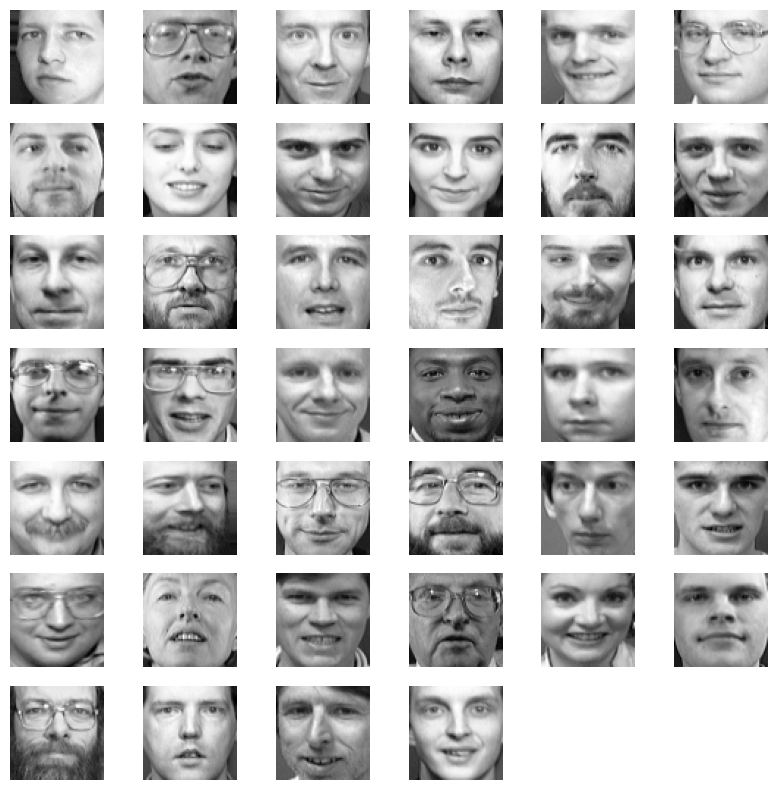

In [48]:
fig = plt.figure(figsize=(10,10))
for i in range(40):
    fig.add_subplot(7,6,i+1)
    idx = np.random.choice(np.where(t==i)[0])
    plt.imshow(X[idx,:].reshape(64,64), cmap='gray')
    plt.axis('off')

In [49]:
np.unique(t, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10], dtype=int64))

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((320, 4096), (320,), (80, 4096), (80,))

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

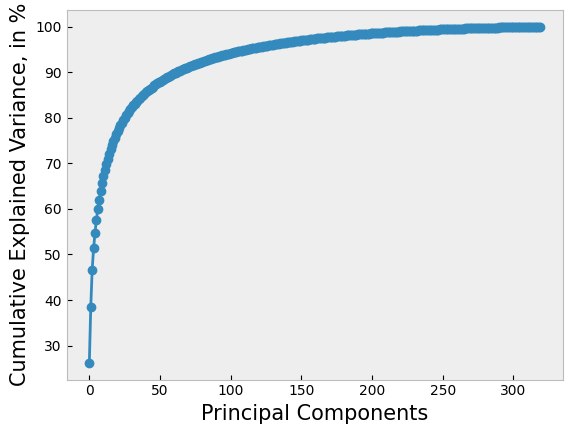

In [52]:
pca = PCA(n_components=320)
pca.fit_transform(X_train_scaled);

plt.plot(100*np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('Principal Components',size=15)
plt.ylabel('Cumulative Explained Variance, in %', size=15);

In [53]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)

(array([ 62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239

In order to explain 90% of the variance in the data, we need to preserve 63 principal components.

Let's project to 2-D so we can plot it:

In [54]:
pca = PCA(n_components=2)
ypca = pca.fit_transform(X_train_scaled)

ypca.shape

(320, 2)

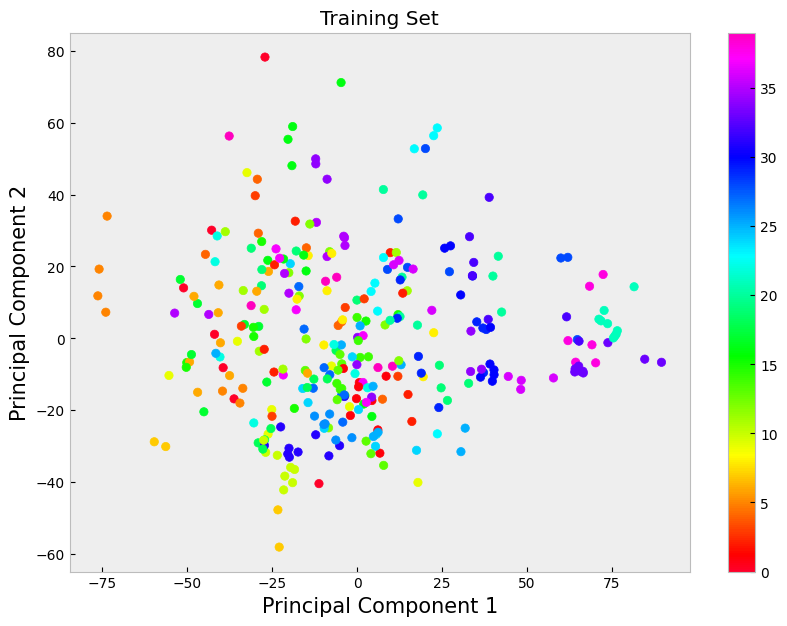

In [55]:
plt.figure(figsize=(10,7))
plt.scatter(ypca[:,0], ypca[:,1], c=t_train, cmap=plt.cm.gist_rainbow)
plt.xlabel('Principal Component 1', size=15)
plt.ylabel('Principal Component 2', size=15)
plt.title('Training Set')
plt.colorbar();

Not that the 40 classes are overlapping in the linear projection space. This is because PCA is **unsupervised**, it does use the class labels *anywhere* in finding the matrix for linear projection.

To apply this transformation in the test set, simply multiply the resultant modal matrix with the scaled test set:

In [56]:
# Transform the test set using the linear transformation found with the training data
ypca_test = pca.transform(X_test_scaled)

ypca_test.shape

(80, 2)

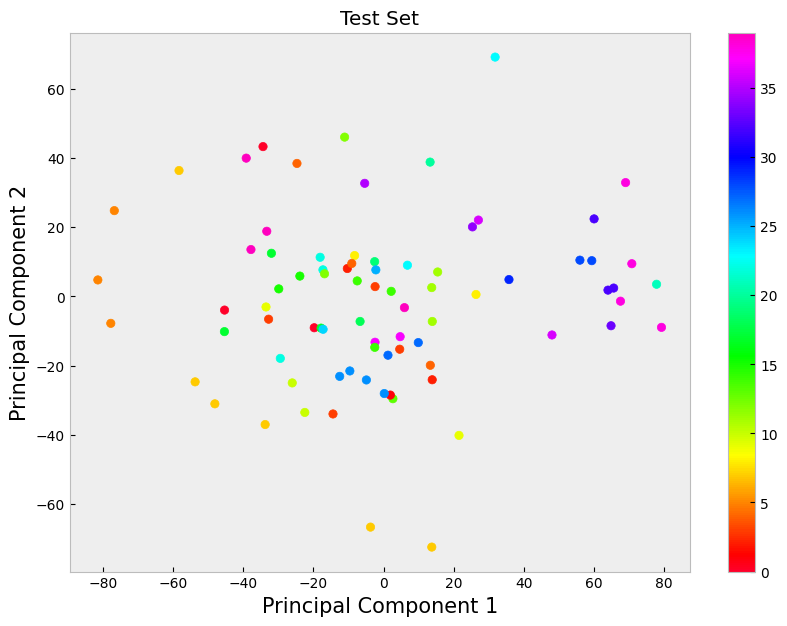

In [57]:
plt.figure(figsize=(10,7))
plt.scatter(ypca_test[:,0], ypca_test[:,1], c=t_test, cmap=plt.cm.gist_rainbow)
plt.xlabel('Principal Component 1', size=15)
plt.ylabel('Principal Component 2', size=15)
plt.title('Test Set')
plt.colorbar();

You can access the linear transformation $\mathbf{A} = \mathbf{U}^T$ using the method ```components_```:

In [58]:
A = pca.components_

A.shape

(2, 4096)

Note that the eigenvectors are described in the original space, that is, they are 4096-dimensional!

Since we are working with images, we can reshape them back to a $64 \times 64$ image and see what are the regions in the image with maximum explained variance! This is called the **eigenfaces**.

Let's now recover 16 eigenvectors and plot them as images:

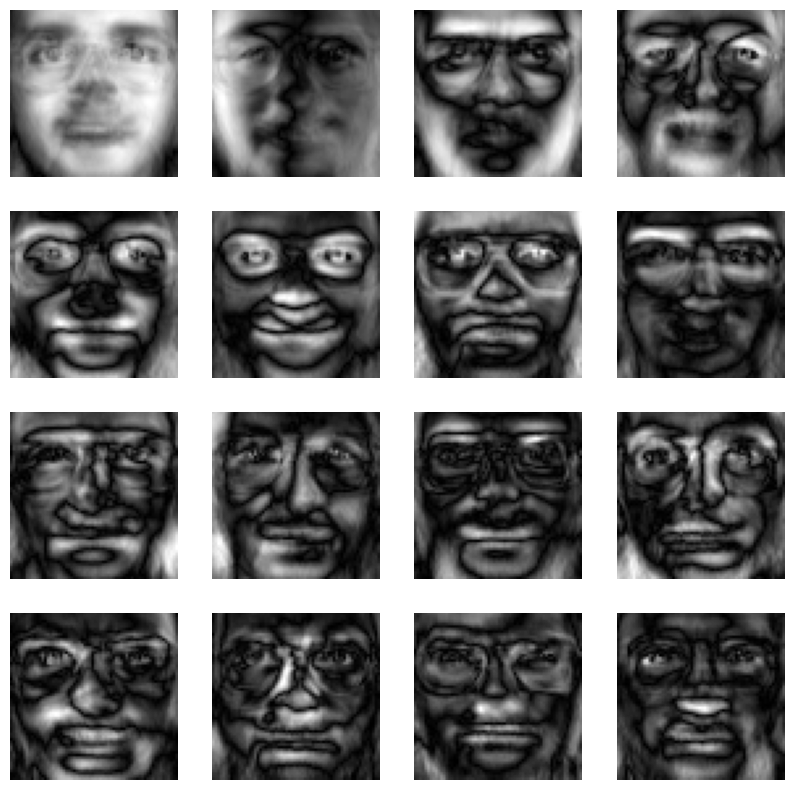

In [66]:
n_components = 16

pca = PCA(n_components=n_components)
ypca = pca.fit_transform(X_train_scaled)

fig=plt.figure(figsize=(10,10))
for i in range(n_components):
    fig.add_subplot(4,4,i+1)
    plt.imshow(abs(pca.components_[i,:].reshape(64,64)),cmap='gray')
    plt.axis('off')

The eigenvectors are describing the regions in the 64x64 image that explain the most variance. the more eigenvectors are kept, the better a reconstruction image will be produced.

Since the projection is given by:

$$\mathbf{Y} = \mathbf{A}\mathbf{X}$$

In order to recover $\mathbf{X}$, we need to left-multiply by the pseudo-inverse of $\mathbf{A}$:

$$\hat{\mathbf{X}} = \mathbf{A}^\dagger\mathbf{Y}$$

We'll code this up next class.

---